## Import all the things that needed

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib as mp
import matplotlib.pyplot as plt
# from metrics import *

mp.rcParams['figure.figsize'] = (14.0, 10.0)

/Users/szalmaf/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Make sure that the pandas version is 0.18.1

In [3]:
pd.__version__

u'0.18.1'

In [4]:
data = pd.read_pickle('data.pd')
data.shape

(9860, 32)

In [5]:
data.dtypes

feature
basement_area                  float64
building_area                  float64
building_condition               int64
building_grade                   int64
deck_area                      float64
employment_percent             float64
heat_source                     object
heat_system                     object
lake_sammamish_view             object
lake_washington_view            object
lot_area                       float64
mean_household_income          float64
median_household_income        float64
mountain_cascades_view          object
mountain_olympics_view          object
mountain_territorial_view       object
num_bath                       float64
num_bed                        float64
num_floor                      float64
other_view                      object
poverty_level                  float64
puget_sound_view                object
skyline_view                    object
small_lake_river_creek_view     object
waterfront_access_p             object
waterfront_footag

# Lets Examine the data

(55000.0, 12000000.0)

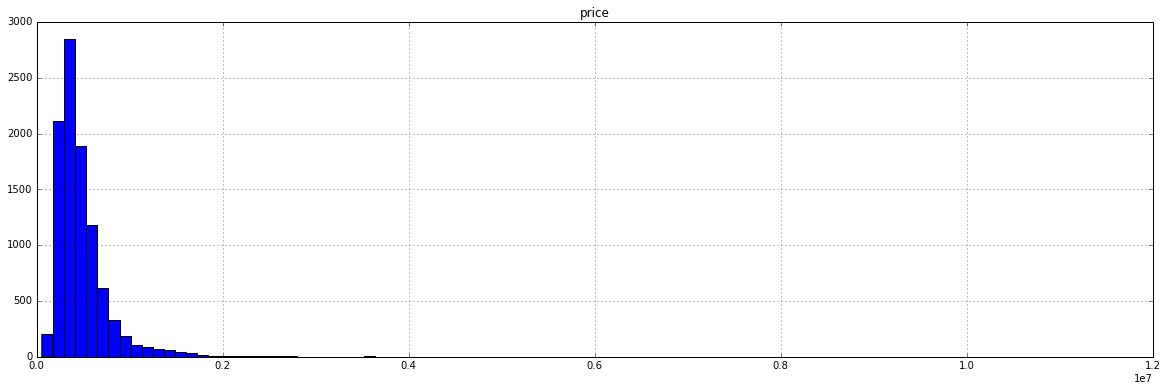

In [6]:
data.hist(column='price', bins=100, figsize=(20,6))
(data['price'].min(),data['price'].max())


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10dd62d10>]], dtype=object)

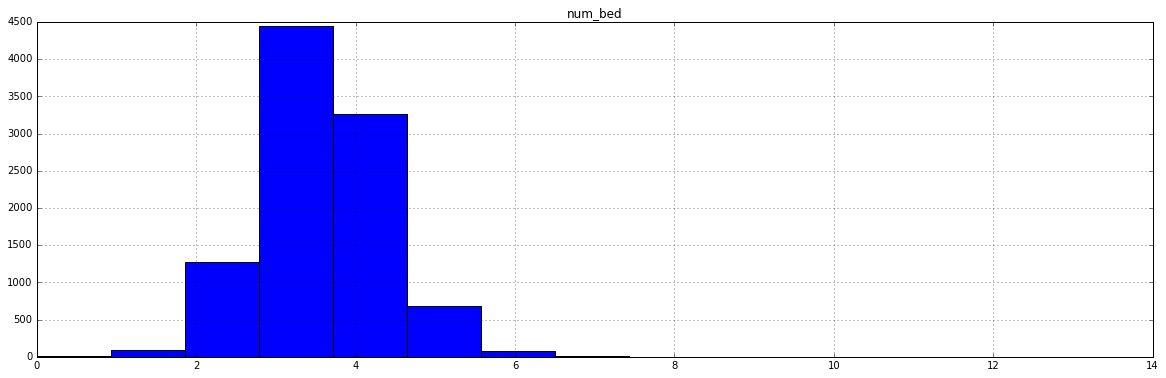

In [7]:
data.hist(column='num_bed', bins=14, figsize=(20,6))

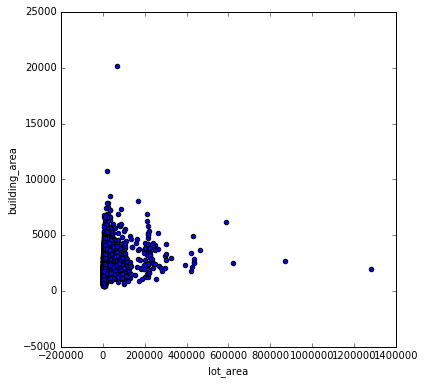

In [8]:
data.plot.scatter(x='lot_area', y='building_area', figsize=(6,6))

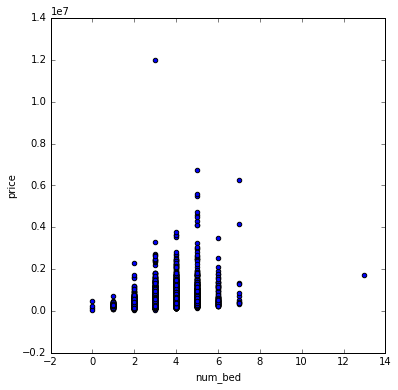

In [9]:
data.plot.scatter(x='num_bed', y='price', figsize=(6,6))

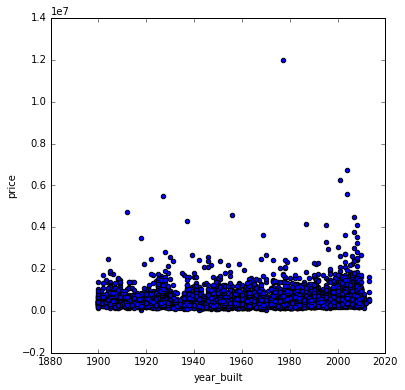

In [10]:
data.plot.scatter(x='year_built', y='price', figsize=(6,6))

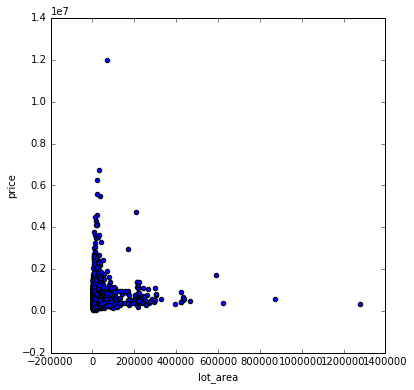

In [11]:
data.plot.scatter(x='lot_area', y='price', figsize=(6,6))

In [12]:
data.heat_source.unique()

array(['2.00', '3.00', '1.00', '4.00', '0.00', '7.00', '5.00', '6.00'], dtype=object)

- Following code is for encoding categorical features using One Hot Encoding

## Encode the categorical variables as one-hot

In [13]:
category_columns = ['heat_source', 'heat_system', 'lake_sammamish_view', 'lake_washington_view', 'mountain_cascades_view', 'mountain_olympics_view',
       'mountain_territorial_view', 'puget_sound_view', u'skyline_view', 'small_lake_river_creek_view', 'waterfront_access_p']

In [14]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse = False)

category_data = data[category_columns]
for col in category_columns:
    category_data[col].map(lambda x: str(x) if x else 'None')

category_data = category_data.reset_index()
one_hot_cols = pd.DataFrame(vectorizer.fit_transform(category_data.T.to_dict().values()), columns=vectorizer.get_feature_names())

one_hot_cols['property_id'] = one_hot_cols['property_id'].map(lambda x: int(x))
one_hot_cols = one_hot_cols.set_index('property_id')

In [15]:
numeric_data = data.select_dtypes(include=['float64'])

numeric_data = numeric_data.drop('price', 1)
#numeric_data = numeric_data.drop('land_val', 1)
#numeric_data = numeric_data.drop('impr_val', 1)

numeric_data.dtypes

feature
basement_area              float64
building_area              float64
deck_area                  float64
employment_percent         float64
lot_area                   float64
mean_household_income      float64
median_household_income    float64
num_bath                   float64
num_bed                    float64
num_floor                  float64
poverty_level              float64
waterfront_footage         float64
year_built                 float64
land_val                   float64
impr_val                   float64
dtype: object

- Rescaling features

In [16]:
scaled_data = pd.DataFrame()
for col in numeric_data.columns:
    scaled_data['{0}_scale'.format(col)] = \
        (numeric_data[col] - numeric_data[col].min())/(numeric_data[col].max() - numeric_data[col].min())

- Standardizing features

In [17]:
zscore_data = pd.DataFrame()
for col in numeric_data.columns:
    zscore_data['{0}_zscore'.format(col)] = \
        (numeric_data[col] - numeric_data[col].mean())/numeric_data[col].std()

- Split data

In [18]:
from datetime import date

transformed_data = numeric_data.join(one_hot_cols, how = 'inner').join(data[['date', 'price']], how = 'inner')
# transformed_data = scaled_data.join(one_hot_cols, how = 'inner').join(data[['date', 'price']], how = 'inner')
# transformed_data = zscore_data.join(one_hot_cols, how = 'inner').join(data[['date', 'price']], how = 'inner')

train = transformed_data[transformed_data['date'] < date(2010, 8, 1)].drop('date', 1)
test = transformed_data[transformed_data['date'] >= date(2010, 8, 1)].drop('date', 1)

train_x = train.drop('price', 1)
train_y = train['price']
train_y_zscored = ((train_y-train_y.mean())/train_y.std())
train_y_scaled = ((train_y-train_y.min())/(train_y.max()-train_y.min()))

test_x = test.drop('price', 1)
test_y = test['price']
test_y_zscored = ((test_y-train_y.mean())/ train_y.std())
test_y_scaled = ((test_y-train_y.min())/(train_y.max()-train_y.min()))

## Metrics
- Zesitimate Accuracy
- AAM (AVM Accuracy Measure) Accuracy

In [19]:
def cal_ppe(y, y_hat):
    abs_error = np.abs((y_hat - y)/y)
    accuracy = np.arange(0, 1.05, 0.01)
    return map(lambda i: float(len(abs_error[abs_error < i]))/float(len(abs_error)), accuracy)

def plot_ppe(title_, ppe):                                                                                                             
                                                                                                                                                                                                                              
    plt.plot(np.arange(0, 1.05, 0.01), ppe, color="red", linewidth=1.5, label='model')                                                                                           
    ppe_zillow = plt.plot([0.05,0.1,0.2],[0.393,0.647,0.881], color='black', linewidth=2.0, label="Zillow")                                                                                                                   
    plt.title(title_)                                                                                                                   
    plt.xlabel('PPE')                                                                                                                   
    plt.ylabel('Error')                                                                                                                   
    plt.legend(loc='upper right')                                                                                                                                

def cal_aam(y, y_hat):
    ppe = cal_ppe(y, y_hat)
    
    ppe_diff = [0]
    for i, upper in enumerate(ppe[1:]):
        ppe_diff.append(ppe[i] - ppe[i-1])
    
    accuracy = np.arange(0, 1.05, 0.01)
    accuracy_square = np.multiply(accuracy, accuracy)
    return np.sum(np.multiply(accuracy_square, ppe_diff))

def adj_r2_score(model,y,yhat):
    """
    Adjusted R square — put fitted linear model, y value, estimated y value in order
    Example:

    In [142]: metrics.r2_score(diabetes_y_train,yhat)
    Out[142]: 0.51222621477934993

    In [144]: adj_r2_score(lm,diabetes_y_train,yhat)
    Out[144]: 0.50035823946984515"""

    from sklearn import metrics
    N= len(y)
    p = len(model.coef_)
    adj = 1 - ((1 -metrics.r2_score(y,yhat))*float(N-1))/(N-p-1)
    return adj

In [20]:
train_x.columns

Index([u'basement_area', u'building_area', u'deck_area', u'employment_percent',
       u'lot_area', u'mean_household_income', u'median_household_income',
       u'num_bath', u'num_bed', u'num_floor', u'poverty_level',
       u'waterfront_footage', u'year_built', u'land_val', u'impr_val',
       u'heat_source=0.00', u'heat_source=1.00', u'heat_source=2.00',
       u'heat_source=3.00', u'heat_source=4.00', u'heat_source=5.00',
       u'heat_source=6.00', u'heat_source=7.00', u'heat_system=0.00',
       u'heat_system=1.00', u'heat_system=2.00', u'heat_system=3.00',
       u'heat_system=4.00', u'heat_system=5.00', u'heat_system=6.00',
       u'heat_system=7.00', u'heat_system=8.00', u'lake_sammamish_view=0.00',
       u'lake_sammamish_view=1.00', u'lake_sammamish_view=2.00',
       u'lake_sammamish_view=3.00', u'lake_sammamish_view=4.00',
       u'lake_washington_view=0.00', u'lake_washington_view=1.00',
       u'lake_washington_view=2.00', u'lake_washington_view=3.00',
       u'lake_washi

## Finally, lets run linear a regression

R^2 score is: 0.944162693146
Adj R^2 score is: 0.944029704959
Train AAM score is: 0.0214888818499
Test AAM score is: 0.0263743674367


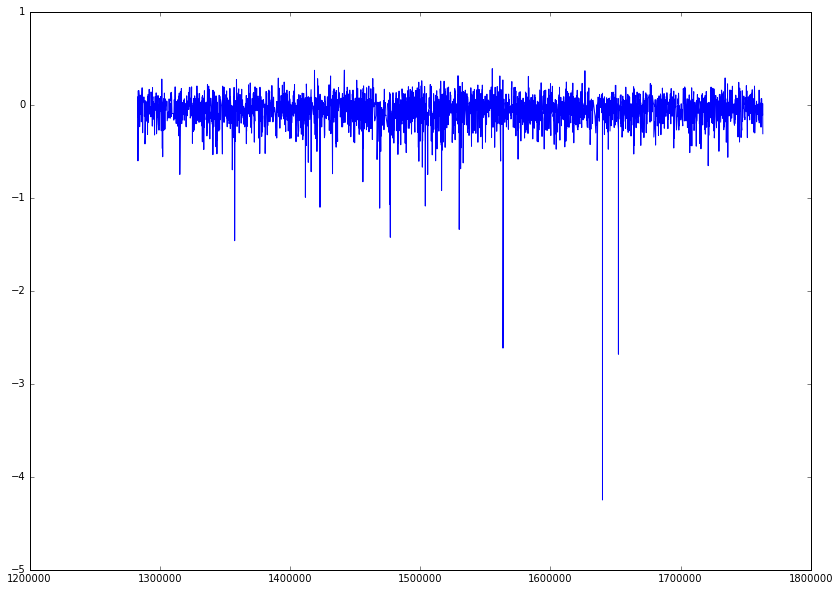

In [21]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
# x_columns = ['lot_area_scale', 'building_area_scale', 'num_bed_scale']
# For z-zcore
# x_columns = ['lot_area_scale', 'building_area_scale', 'num_bed_scale']
# For unscaled
#x_columns = ['land_val', 'impr_val' , 'lot_area', 'building_area', 'num_bed']
x_columns = numeric_data.columns.values
#x_columns = train_x.columns.values

regressor = regressor.fit(train_x[x_columns], train_y)
train_y_hat = regressor.predict(train_x[x_columns])

test_y_hat = regressor.predict(test_x[x_columns])

print 'R^2 score is:', regressor.score(train_x[x_columns], train_y)
print 'Adj R^2 score is:', adj_r2_score(regressor, train_y, train_y_hat)

print 'Train AAM score is:', cal_aam(train_y, train_y_hat)
print 'Test AAM score is:', cal_aam(test_y, test_y_hat)
#plot_ppe("Linear Regression", cal_ppe(test_y, test_y_hat))

plt.plot((test_y-test_y_hat)/test_y)

/Users/szalmaf/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


R^2 score is: 0.933234929584
AAM score is: 0.0273768426843


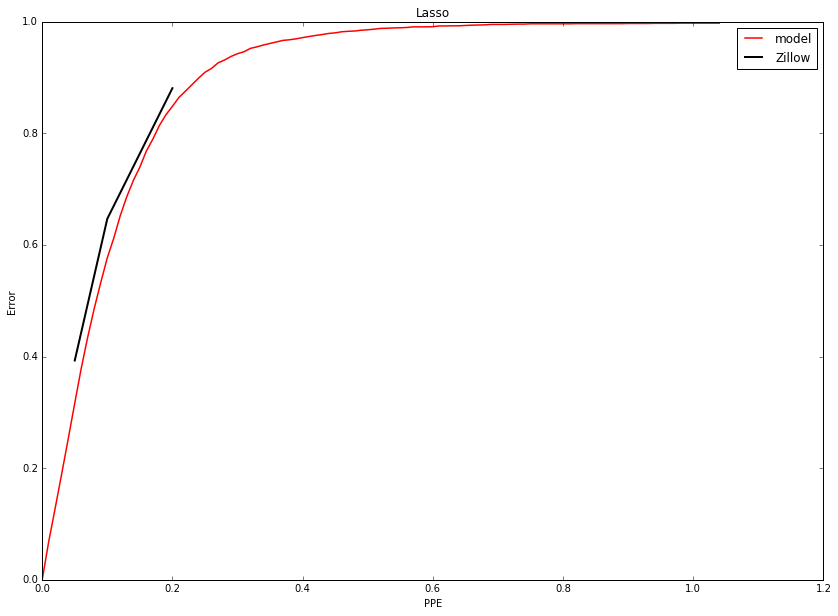

In [22]:
from sklearn.linear_model import Lasso

regressor = Lasso(alpha = .0005)
regressor = regressor.fit(train_x, train_y)
test_y_hat = regressor.predict(test_x)

print 'R^2 score is:', regressor.score(test_x, test_y)
print 'AAM score is:', cal_aam(test_y, test_y_hat)
plot_ppe("Lasso", cal_ppe(test_y, test_y_hat))

#plt.scatter(test_y, test_y_hat)

R^2 score is: 0.933342572445
AAM score is: 0.0273523377338


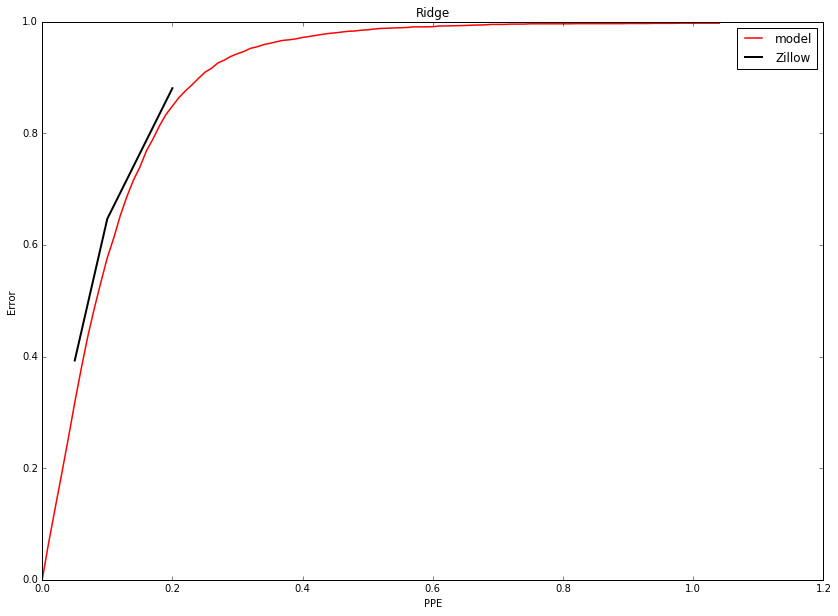

In [23]:
from sklearn.linear_model import Ridge

regressor = Ridge(alpha = 0.4)
regressor = regressor.fit(train_x, train_y)
test_y_hat = regressor.predict(test_x)

print 'R^2 score is:', regressor.score(test_x, test_y)
print 'AAM score is:', cal_aam(test_y, test_y_hat)
plot_ppe("Ridge", cal_ppe(test_y, test_y_hat))

#plt.scatter(test_y, test_y_hat)

R^2 score is: 0.963967817997
Train AAM score is: 0.006005654102
Test AAM score is: 0.0306174642464


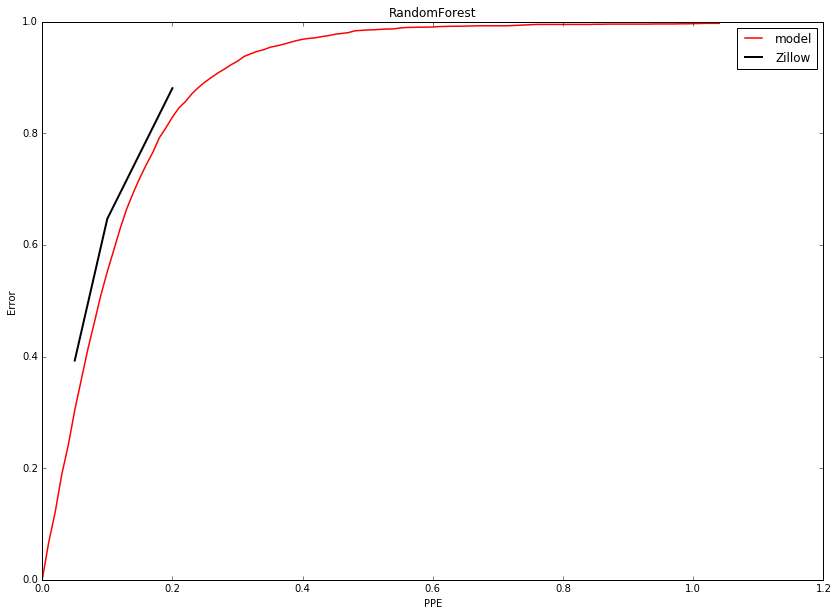

In [24]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_jobs= 4)
regressor = regressor.fit(train_x, train_y)
test_y_hat = regressor.predict(test_x)
train_y_hat = regressor.predict(train_x)

#print(sorted(zip(train_x.columns, regressor.feature_importances_), key=lambda tup: tup[1], reverse=True))

print 'R^2 score is:', regressor.score(train_x, train_y)
print 'Train AAM score is:', cal_aam(train_y, train_y_hat)
print 'Test AAM score is:', cal_aam(test_y, test_y_hat)
plot_ppe("RandomForest", cal_ppe(test_y, test_y_hat))

#plt.scatter(test_y, test_y_hat)

In [25]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

#scorer = make_scorer(cal_aam, greater_is_better = False)
#scorer = 'mean_absolute_error'
scorer = 'r2'

gs = GridSearchCV(regressor, {
        'max_depth'        : [5, 7, 9, 11, 15, 17],
        'min_samples_split': [11, 13, 17, 19, 21],
        'min_samples_leaf' : [10,11,12,13,14,15],
        'min_weight_fraction_leaf': [0],
        'max_leaf_nodes'   : [110, 130, 150, 170, 200],
        'max_features'     : [0.75],
    }, n_jobs = 32, scoring = scorer, verbose=1).fit(train_x,train_y)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    4.8s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:   13.2s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:   28.2s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:   48.2s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:  1.2min
[Parallel(n_jobs=32)]: Done 2386 tasks      | elapsed:  1.8min
[Parallel(n_jobs=32)]: Done 2700 out of 2700 | elapsed:  2.1min finished


In [26]:
gs.best_params_

{'max_depth': 9,
 'max_features': 0.75,
 'max_leaf_nodes': 150,
 'min_samples_leaf': 10,
 'min_samples_split': 21,
 'min_weight_fraction_leaf': 0}

R^2 score is: 0.863367536403
AAM score is: 0.0301179042904


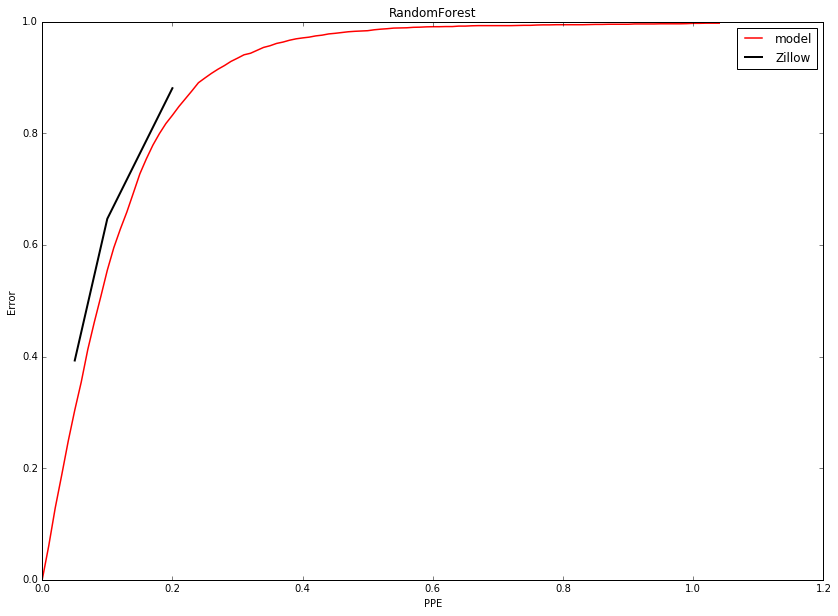

In [27]:
regressor = RandomForestRegressor(**gs.best_params_)
regressor = regressor.fit(train_x, train_y)
test_y_hat = regressor.predict(test_x)

print 'R^2 score is:', regressor.score(train_x, train_y)
print 'AAM score is:', cal_aam(test_y, test_y_hat)
plot_ppe("RandomForest", cal_ppe(test_y, test_y_hat))

In [20]:
# import seaborn as sns
# nd2 = data.select_dtypes(include=['float64'])
# g=sns.PairGrid(nd2, y_vars=["price"], x_vars=["lot_area", "impr_val", "land_val", "impr_val", "building_area"], size=6)
# g.map(sns.regplot, color=".3")